# Purpose of notebook
This notebook is an updated version of the analysis of SPC wave data for Nanumanga (will include Nanumea).
This updated version considers that the transects are not evenly spaced.

# File Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from processing_waves import averaging_waves,calc_wave_power
import json
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import netCDF4
import math
import sys
import os
import itertools
import scipy.stats

# Process the Wave data 

In [4]:
nanumanga_dates = list(pd.read_csv('Nanumaga_dates.tsv',sep='\t'))
nanumanga_dates = \
    [pd.to_datetime(x) for x in nanumanga_dates]


nanumea_dates = list(pd.read_csv('Nanumea_dates.tsv',sep='\t'))
nanumea_dates = \
    [pd.to_datetime(x) for x in nanumea_dates]


In [5]:
# (pd.to_datetime(nanumanga_dates[0])-pd.to_datetime(nanumanga_dates[1])).days

In [6]:
# averaging_waves('SuperPoint_Nanumaga.nc','Nanumaga')
# # averaging_waves('SuperPoint_Nanumea.nc','digitised_averages_nanumea')

In [7]:
# # Find all the months and years
# atoll = 'Nanumaga'
# with open('time_{}.txt'.format(atoll)) as f:
#     times = f.readlines()
        
# years = np.unique(pd.DatetimeIndex(times).year)
# months = np.arange(1,13,1)

In [8]:
# total_wave_power_list = list(map(calc_wave_power,
#                                  nanumanga_dates[:-1],
#                                  nanumanga_dates[1:],
#                                 ['digitised_averages_nanumanga']*len(nanumanga_dates[1:]),
#                                 ['Nanumaga']*len(nanumanga_dates[1:])))

# total_wave_power = {(year_1,year_2):x for x,year_1,year_2 in zip(total_wave_power_list,nanumanga_dates[:-1],nanumanga_dates[1:])}

# with open('processed_waves/{}.json'.format(json_file_name), 'w') as fp:
#     json.dump(total_wave_power, fp)

In [9]:
nanumanga_dates = [x.to_pydatetime() for x in nanumanga_dates]
nanumanga_dates = {x.year:x for x in nanumanga_dates}

nanumea_dates = [x.to_pydatetime() for x in nanumea_dates]
nanumea_dates = {x.year:x for x in nanumea_dates}

In [10]:
# years = np.arange(1980,2022,1)
# months = np.arange(1,13,1)

In [11]:
# monthly_list = []

# for year in years:
#     for month in months:
#         monthly_list.append(pd.to_datetime('01/{month}/{year}'.format(month=month,year=year)))

In [12]:
# averaging_waves('SuperPoint_Nanumaga.nc',monthly_list,'monthly_averages')

# Loading wave data 

In [13]:
with open('processed_waves/{}.json'.format('Nanumaga'), 'r') as f:
    total_wave_power_nanumanga = json.load(f)
    
with open('processed_waves/{}.json'.format('Nanumea'), 'r') as f:
    total_wave_power_nanumea = json.load(f)

In [14]:
event_sizes_nanumanga = list(total_wave_power_nanumanga[list(total_wave_power_nanumanga.keys())[0]]['events'].keys())
event_sizes_nanumea = list(total_wave_power_nanumea[list(total_wave_power_nanumea.keys())[0]]['events'].keys())


In [15]:
for time_frames,item in total_wave_power_nanumanga.items():
    item['events'][event_sizes_nanumanga[0]]

In [16]:
for k,v in item['events'][event_sizes_nanumanga[0]].items():
    time_frames.split(', ')[0][1:]

In [17]:
datetime.datetime.strptime(k,"%Y-%m-%d %H:%M:%S")

datetime.datetime(2019, 12, 31, 22, 0)

In [18]:
time_frames.split(', ')[0][1:].strip('Timestamp(').strip(')')

"'2019-05-26 00:00:00'"

In [19]:
k

'2019-12-31 22:00:00'

In [20]:
time_frames.split(', ')[0][1:].strip('Timestamp(').strip(')')

"'2019-05-26 00:00:00'"

In [21]:
datetime.datetime.strptime(time_frames.split(', ')[0][1:].strip('Timestamp(').strip(')').strip("'"),"%Y-%m-%d %H:%M:%S")

datetime.datetime(2019, 5, 26, 0, 0)

In [22]:

def event_stats(total_wave_power,event_size):
    medium_list = []
    events_summarised = {}

    for time_frames,item in total_wave_power.items():
        df = pd.DataFrame.from_dict({(datetime.datetime.strptime(k,"%Y-%m-%d %H:%M:%S")):
                                     v for k,v in item['events'][event_size].items()},
                                  orient='index')
        df['key'] = [tuple((datetime.datetime.strptime(time_frames.split(', ')[0][1:].strip('Timestamp(').strip(')').strip("'"),"%Y-%m-%d %H:%M:%S"),
                    datetime.datetime.strptime(time_frames.split(', ')[1][:-1].strip('Timestamp(').strip(')').strip("'"),"%Y-%m-%d %H:%M:%S")))]*len(df)
        
        df.rename(columns={0:'P'},inplace=True)
        df.sort_index(inplace=True)

        # Check to see if new event
        df['new_event'] = False
        df.loc[np.min(df.index),'new_event'] = True

        for idx1,idx2 in zip(df.index[:-1],df.index[1:]):
            if not (idx2-idx1)<datetime.timedelta(days=1):
                df.loc[idx2,'new_event'] = True

        events_dict = {}

        df_events = pd.DataFrame(df.iloc[0,:]).T
        i=0

        for index,row in df.iterrows():
            if row.new_event==False:
                df_events = df_events.append(row)
            elif row.new_event==True:
                if i!=0:
                    events_dict.update({
                        index:df_events
                    })
                df_events = pd.DataFrame(df.loc[index,:]).T
                i+=1


        for key,item in events_dict.items():
            hours = (np.max(item.index)-np.min(item.index)+datetime.timedelta(hours=1)).seconds/3600
            mean_power = np.mean(item.P)
            max_power = np.max(item.P)
            sum_power = np.sum(item.P)

            events_summarised.update({
                (time_frames,key):{
                    'hours':hours,
                    'mean_power':mean_power,
                    'max_power':max_power,
                    'sum_power':sum_power
                }
            })

    df_events_stats = pd.DataFrame.from_dict(events_summarised,orient='index')
    
    return(df_events_stats)


In [23]:
event_size_nanumanga_dict = {size:event_stats(total_wave_power_nanumanga,size) for size in event_sizes_nanumanga}
event_size_nanumea_dict = {size:event_stats(total_wave_power_nanumea,size) for size in event_sizes_nanumea}

# Compare Events to Islet area

In [24]:
df_areas = pd.read_csv('areas.csv')
df_areas_nanumanga = df_areas.copy()
df_areas_nanumanga['year'] = [nanumanga_dates[year] if year in nanumanga_dates else np.nan for year in df_areas.year]
df_areas_nanumanga.dropna(inplace=True)
df_areas_nanumanga = df_areas_nanumanga[(df_areas_nanumanga.id==1)&(df_areas_nanumanga.islet=='Nanumanga')]
df_areas_nanumanga = df_areas_nanumanga.sort_values('proxy')

df_areas = pd.read_csv('areas.csv')
df_areas_nanumea = df_areas.copy()
df_areas_nanumea['year'] = [nanumea_dates[year] if year in nanumea_dates else np.nan for year in df_areas.year]
df_areas_nanumea.dropna(inplace=True)
df_areas_nanumea = df_areas_nanumea[(df_areas_nanumea.id==1)&(df_areas_nanumea.islet=='Nanumanga')]
df_areas_nanumea = df_areas_nanumea.sort_values('proxy')

In [25]:
import seaborn as sns

In [26]:
cmap_as_list1 = sns.diverging_palette(230, 20, as_cmap=True)(np.linspace(0, 1, 5))

In [27]:
len(cmap_as_list1)

5

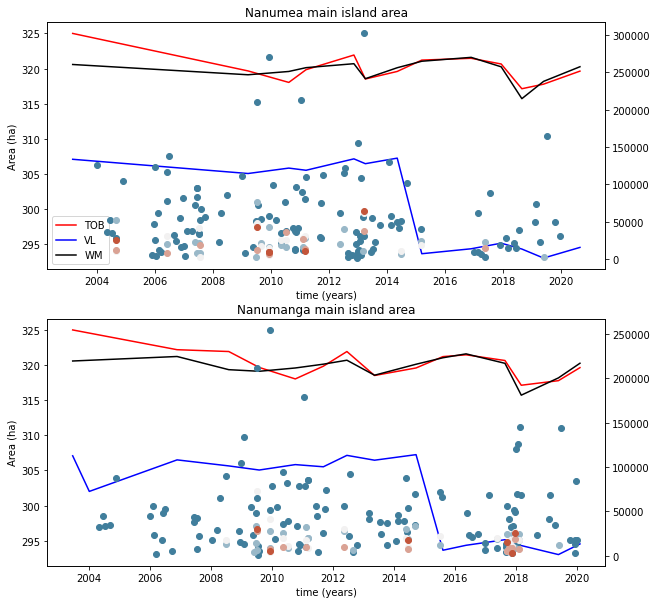

In [88]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

handles_list = []
output_list = []
cols = ['r','b','k']
i = 0

for index,group in df_areas_nanumea.groupby(['id','islet','proxy']):
    group = group.sort_values('year')
    group = group[group['area (ha)']!=0]
#     group = group[group['year']>=2000]
    output, = ax1.plot(group.year,group['area (ha)'],c=cols[i])    
    output_list.append(output)
    handles_list.append(index[-1])
    i+=1
    
i = 0
for index,group in df_areas_nanumanga.groupby(['id','islet','proxy']):
    group = group.sort_values('year')
    group = group[group['area (ha)']!=0]
#     group = group[group['year']>=2000]
    ax2.plot(group.year,group['area (ha)'],c=cols[i])
    i+=1
    
for ax in ax1,ax2:
    ax.set_xlabel('time (years)')
    ax.set_ylabel('Area (ha)')
#     ax.set_xticks(np.arange(2000,2022,2))
    
ax1.legend(output_list,handles_list)
ax1.set_title('Nanumea main island area')
ax2.set_title('Nanumanga main island area')


ax1b = ax1.twinx()
ax2b = ax2.twinx()

alpha_min = 0.1
alpha_max = 1

for x,c in zip(event_size_nanumea_dict.keys(),cmap_as_list1):
    event_times = [x[1] for x in event_size_nanumea_dict[x].index]
    ax1b.scatter(event_times,
             list(event_size_nanumea_dict[x].sum_power),
#                 alpha=alpha,
                color=c)

for x,c in zip(event_size_nanumanga_dict.keys(),cmap_as_list1):
    event_times = [x[1] for x in event_size_nanumanga_dict[x].index]
    ax2b.scatter(event_times,
             list(event_size_nanumanga_dict[x].sum_power),
#                 alpha=alpha,
                color=c)


plt.show()

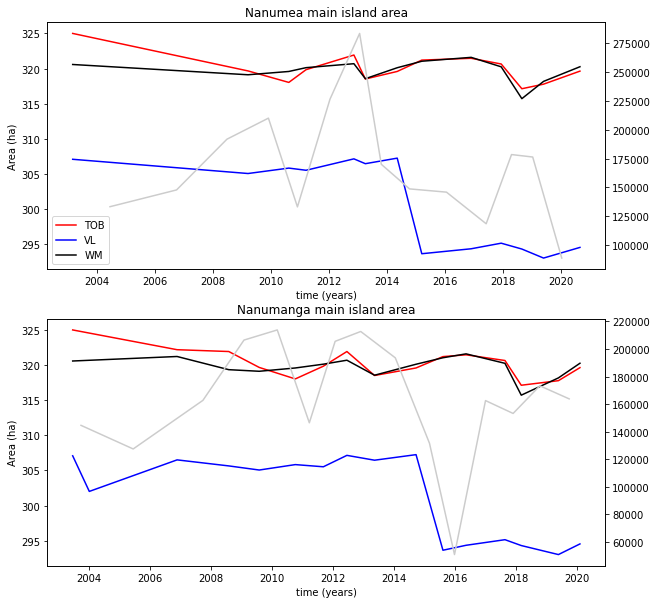

In [84]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

handles_list = []
output_list = []
cols = ['r','b','k']
i = 0

for index,group in df_areas_nanumea.groupby(['id','islet','proxy']):
    group = group.sort_values('year')
    group = group[group['area (ha)']!=0]
#     group = group[group['year']>=2000]
    output, = ax1.plot(group.year,group['area (ha)'],c=cols[i])    
    output_list.append(output)
    handles_list.append(index[-1])
    i+=1
    
i = 0
for index,group in df_areas_nanumanga.groupby(['id','islet','proxy']):
    group = group.sort_values('year')
    group = group[group['area (ha)']!=0]
#     group = group[group['year']>=2000]
    ax2.plot(group.year,group['area (ha)'],c=cols[i])
    i+=1
    
for ax in ax1,ax2:
    ax.set_xlabel('time (years)')
    ax.set_ylabel('Area (ha)')
#     ax.set_xticks(np.arange(2000,2022,2))
    
ax1.legend(output_list,handles_list)
ax1.set_title('Nanumea main island area')
ax2.set_title('Nanumanga main island area')


ax1b = ax1.twinx()
ax2b = ax2.twinx()

mean_dict = {}

for index,item in total_wave_power_nanumea.items():
    index = index.replace('Timestamp','')
    index = index.replace('(','')
    index = index.replace(')','')
    index = index.replace("'",'')
    index = index.replace(" 00:00:00",'')
    index1,index2 = index.split(', ')
    
    x,y,z = index1.split('-')
    date1 = datetime.datetime(int(x),int(y),int(z))
    a,b,c = index2.split('-')
    date2 = datetime.datetime(int(a),int(b),int(c))
    
#     ax1b.plot([date1,date2],[item['daily_mean'],item['daily_mean']],c='0.5',zorder=-1000)
    
    mean_dict.update({
        date1+(date2-date1)/2:item['daily_mean']
    })

df_mean = pd.DataFrame.from_dict(mean_dict,orient='index')

ax1b.plot(df_mean.index,df_mean[0],c='0.8',zorder=-1000)


mean_dict = {}

for index,item in total_wave_power_nanumanga.items():
    index = index.replace('Timestamp','')
    index = index.replace('(','')
    index = index.replace(')','')
    index = index.replace("'",'')
    index = index.replace(" 00:00:00",'')
    index1,index2 = index.split(', ')
    
    x,y,z = index1.split('-')
    date1 = datetime.datetime(int(x),int(y),int(z))
    a,b,c = index2.split('-')
    date2 = datetime.datetime(int(a),int(b),int(c))
    
#     ax2b.plot([date1,date2],[item['daily_mean'],item['daily_mean']],c='0.5',zorder=-1000)
    
    mean_dict.update({
        date1+(date2-date1)/2:item['daily_mean']
    })

df_mean = pd.DataFrame.from_dict(mean_dict,orient='index')

ax2b.plot(df_mean.index,df_mean[0],c='0.8',zorder=-1000)

plt.show()


# Looking at sea-levels

In [117]:
df_funafuti_tides = pd.read_csv('/src/Dataset/Additional_data/Tidal_data/Data/h025.csv')
df_funafuti_tides.index = [datetime.datetime(y,m,d) for y,m,d in zip(df_funafuti_tides.year,df_funafuti_tides.month,df_funafuti_tides.date)]


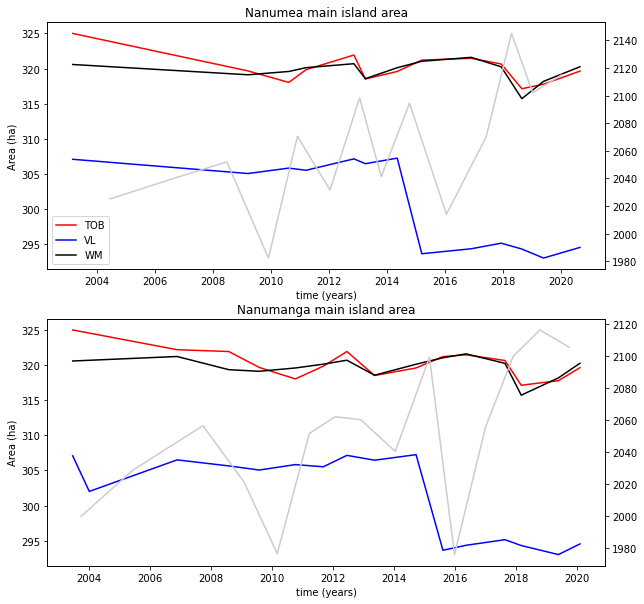

In [121]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

handles_list = []
output_list = []
cols = ['r','b','k']
i = 0

for index,group in df_areas_nanumea.groupby(['id','islet','proxy']):
    group = group.sort_values('year')
    group = group[group['area (ha)']!=0]
#     group = group[group['year']>=2000]
    output, = ax1.plot(group.year,group['area (ha)'],c=cols[i])    
    output_list.append(output)
    handles_list.append(index[-1])
    i+=1
    
i = 0
for index,group in df_areas_nanumanga.groupby(['id','islet','proxy']):
    group = group.sort_values('year')
    group = group[group['area (ha)']!=0]
#     group = group[group['year']>=2000]
    ax2.plot(group.year,group['area (ha)'],c=cols[i])
    i+=1
    
for ax in ax1,ax2:
    ax.set_xlabel('time (years)')
    ax.set_ylabel('Area (ha)')
#     ax.set_xticks(np.arange(2000,2022,2))
    
ax1.legend(output_list,handles_list)
ax1.set_title('Nanumea main island area')
ax2.set_title('Nanumanga main island area')


ax1b = ax1.twinx()
ax2b = ax2.twinx()

mean_dict = {}

for index,item in total_wave_power_nanumea.items():
    index = index.replace('Timestamp','')
    index = index.replace('(','')
    index = index.replace(')','')
    index = index.replace("'",'')
    index = index.replace(" 00:00:00",'')
    index1,index2 = index.split(', ')
    
    x,y,z = index1.split('-')
    date1 = datetime.datetime(int(x),int(y),int(z))
    a,b,c = index2.split('-')
    date2 = datetime.datetime(int(a),int(b),int(c))
    
    mean_SL = np.mean(df_funafuti_tides[(df_funafuti_tides.index>date1)&(df_funafuti_tides.index<date2)&(df_funafuti_tides.level>0)].level)

    mean_dict.update({
        date1+(date2-date1)/2:mean_SL
    })

df_mean = pd.DataFrame.from_dict(mean_dict,orient='index')

ax1b.plot(df_mean.index,df_mean[0],c='0.8',zorder=-1000)

mean_dict = {}
    
for index,item in total_wave_power_nanumanga.items():
    index = index.replace('Timestamp','')
    index = index.replace('(','')
    index = index.replace(')','')
    index = index.replace("'",'')
    index = index.replace(" 00:00:00",'')
    index1,index2 = index.split(', ')
    
    x,y,z = index1.split('-')
    date1 = datetime.datetime(int(x),int(y),int(z))
    a,b,c = index2.split('-')
    date2 = datetime.datetime(int(a),int(b),int(c))
    
    mean_SL = np.mean(df_funafuti_tides[(df_funafuti_tides.index>date1)&(df_funafuti_tides.index<date2)&(df_funafuti_tides.level>0)].level)
    
    mean_dict.update({
        date1+(date2-date1)/2:mean_SL
    })

df_mean = pd.DataFrame.from_dict(mean_dict,orient='index')

ax2b.plot(df_mean.index,df_mean[0],c='0.8',zorder=-1000)


# Tides 

In [134]:

df_nanumanga_tide_times = pd.read_csv('/src/Dataset/D9_Tuvalu_shoreline/nanumaga_time_with_tide.csv',index_col=[0])
df_nanumea_tide_times = pd.read_csv('/src/Dataset/D9_Tuvalu_shoreline/nanumea_time_with_tide.csv',index_col=[0])


In [140]:
df_nanumea_tide_times['datetime'] = [datetime.datetime(y,m,d) for y,m,d in zip(df_nanumea_tide_times.year,df_nanumea_tide_times.month,df_nanumea_tide_times.date)]
df_nanumanga_tide_times['datetime'] = [datetime.datetime(y,m,d) for y,m,d in zip(df_nanumanga_tide_times.year,df_nanumanga_tide_times.month,df_nanumanga_tide_times.date)]


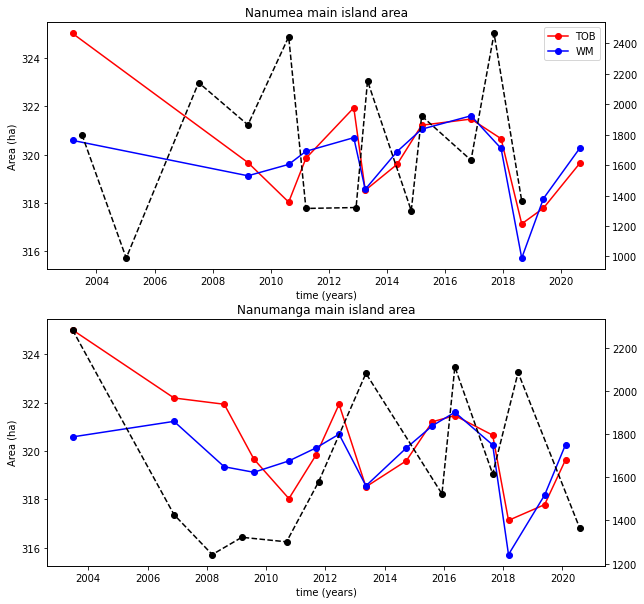

In [148]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

handles_list = []
output_list = []
cols = ['r','b','k']
i = 0

for index,group in df_areas_nanumea.groupby(['id','islet','proxy']):
    if index[-1]=='VL':
        continue
    group = group.sort_values('year')
    group = group[group['area (ha)']!=0]
#     group = group[group['year']>=2000]
    output, = ax1.plot(group.year,group['area (ha)'],c=cols[i],marker='o')    
    output_list.append(output)
    handles_list.append(index[-1])
    i+=1
    
i = 0
for index,group in df_areas_nanumanga.groupby(['id','islet','proxy']):
    if index[-1]=='VL':
        continue
    group = group.sort_values('year')
    group = group[group['area (ha)']!=0]
#     group = group[group['year']>=2000]
    ax2.plot(group.year,group['area (ha)'],c=cols[i],marker='o')
    i+=1
    
for ax in ax1,ax2:
    ax.set_xlabel('time (years)')
    ax.set_ylabel('Area (ha)')
#     ax.set_xticks(np.arange(2000,2022,2))
    
ax1.legend(output_list,handles_list)
ax1.set_title('Nanumea main island area')
ax2.set_title('Nanumanga main island area')

ax1b = ax1.twinx()
ax2b = ax2.twinx()


ax1b.plot(df_nanumea_tide_times.datetime,df_nanumea_tide_times.level,marker='o',ls='--',c='k')
ax2b.plot(df_nanumanga_tide_times.datetime,df_nanumanga_tide_times.level,marker='o',ls='--',c='k')



# Shoreline change

In [ ]:
group = df_areas_nanumanga[df_areas_nanumanga.proxy=='TOB']
group['days'] = [(x-np.min(group.year)).days for x in group.year]

for (index1,group1),(index2,group2) in zip(group[:-1].iterrows(),group[1:].iterrows()):
    if (group2['area (ha)']<group1['area (ha)']):
        y1 = group1['area (ha)']
        y2 = group2['area (ha)']
        
        x1 = group1['days']
        x2 = group2['days']

# Daily Mean Changes 

In [ ]:
daily_mean_dict = {}

for time_frames,item in total_wave_power_nanumanga.items():

    daily_mean = item['daily_mean']

    time_frame = tuple((datetime.datetime.strptime(time_frames.split(', ')[0][1:].strip('Timestamp(').strip(')').strip("'"),"%Y-%m-%d %H:%M:%S"),
                datetime.datetime.strptime(time_frames.split(', ')[1][:-1].strip('Timestamp(').strip(')').strip("'"),"%Y-%m-%d %H:%M:%S")))

    daily_mean_dict.update({
        time_frame:daily_mean
    })
    
df_daily_mean = pd.DataFrame.from_dict(daily_mean_dict,orient='index')
df_daily_mean['start_date'] = [x[0] for x in df_daily_mean.index]
df_daily_mean['end_date'] = [x[1] for x in df_daily_mean.index]
df_daily_mean = df_daily_mean.rename(columns={0:'daily_mean'}).reset_index(drop=True)

In [ ]:
df_daily_mean['mean_times'] = [x+datetime.timedelta(days=(y-x).days) for x,y in zip(df_daily_mean.start_date,df_daily_mean.end_date)]

In [ ]:
fig = plt.figure(figsize=(10,10))

ax1 = plt.subplot2grid((2,1),(0,0))
ax2 = plt.subplot2grid((2,1),(1,0))

handles_list = []
output_list = []
cols = ['r','b','k']
i = 0

for index,group in df_areas_nanumea.groupby(['id','islet','proxy']):
    group = group.sort_values('year')
    group = group[group['area (ha)']!=0]
#     group = group[group['year']>=2000]
    output, = ax1.plot(group.year,group['area (ha)'],c=cols[i])    
    output_list.append(output)
    handles_list.append(index[-1])
    i+=1
    
i = 0
for index,group in df_areas_nanumanga.groupby(['id','islet','proxy']):
    group = group.sort_values('year')
    group = group[group['area (ha)']!=0]
#     group = group[group['year']>=2000]
    ax2.plot(group.year,group['area (ha)'],c=cols[i])
    i+=1
    
for ax in ax1,ax2:
    ax.set_xlabel('time (years)')
    ax.set_ylabel('Area (ha)')
#     ax.set_xticks(np.arange(2000,2022,2))
    
ax1.legend(output_list,handles_list)
ax1.set_title('Nanumea main island area')
ax2.set_title('Nanumanga main island area')


ax1b = ax1.twinx()
ax2b = ax2.twinx()

alpha_min = 0.1
alpha_max = 1

ax1b.bar(x=df_daily_mean.mean_times,height=df_daily_mean.daily_mean)


plt.show()

In [ ]:
plt.bar(x=np.arange(0,len(df_daily_mean),1),height=df_daily_mean.daily_mean)

In [ ]:
df_test = df_daily_mean.copy()
first_date = np.min(df_test.start_date)
df_test['start_date'] = [(x-first_date).days for x in df_test.start_date]
df_test['end_date'] = [(x-first_date).days for x in df_test.end_date]

[plt.axvspan(xmin=x.start_date,
             xmax=x.end_date,
             ymin=0,ymax=x.daily_mean) for index,x in df_test.iterrows()]


# See if there is an exp function that could fit

In [ ]:
df_test.start_date

def (a,b):
    y=a*np.exp(b*x)

In [ ]:
[(x.start_date,x.end_date,0,x.daily_mean) for index,x in df_test.iterrows()]

In [ ]:
df_test

In [ ]:
[x.mean_times.to_pydatetime() for index,x in df_daily_mean.iterrows()]

In [ ]:
df_daily_mean

In [ ]:
list(event_size_nanumea_dict.keys())


In [ ]:
plt.plot(event_times,
         list(event_size_dict['(90, 100)'].sum_power))

In [ ]:
event_size_dict

In [ ]:
list(event_size_dict['(90, 100)'].sum_power)

In [ ]:
group

In [ ]:
type(event_size_dict['(90, 100)'].sum_power[0])

In [ ]:
group

In [ ]:
total_wave_power.pop('2021-06-06 00:00:00')

medium_list = []
events_summarised = {}

for time_frames,item in total_wave_power.items():
    df = pd.DataFrame.from_dict({datetime.datetime.strptime(k,"%Y-%m-%d %H:%M:%S"):v for k,v in item['medium_events'].items()},
                              orient='index')
    df['key'] = datetime.datetime.strptime(time_frames,"%Y-%m-%d %H:%M:%S") 
    df.rename(columns={0:'P'},inplace=True)
    df.sort_index(inplace=True)
    
    # Check to see if new event
    df['new_event'] = False
    df.loc[np.min(df.index),'new_event'] = True

    for idx1,idx2 in zip(df.index[:-1],df.index[1:]):
        if not (idx2-idx1)<datetime.timedelta(days=1):
            df.loc[idx2,'new_event'] = True
            
    print(len(df[df['new_event']==True]))
    
#     medium_list.append(
#         df
#         #datetime.datetime.strptime(time_frames,"%Y-%m-%d %H:%M:%S"):item
#     )
# df_events = pd.concat(medium_list)
# df_events = df_events.dropna()

    events_dict = {}

    df_events = pd.DataFrame(df.iloc[0,:]).T
    i=0
    
    for index,row in df.iterrows():
        if row.new_event==False:
            df_events = df_events.append(row)
        elif row.new_event==True:
            if i!=0:
                events_dict.update({
                    index:df_events
                })
            df_events = pd.DataFrame(df.loc[index,:]).T
            i+=1
            
    
    for key,item in events_dict.items():
        hours = (np.max(item.index)-np.min(item.index)+datetime.timedelta(hours=1)).seconds/3600
        mean_power = np.mean(item.P)
        max_power = np.max(item.P)
        
        events_summarised.update({
            (time_frames,key):{
                'hours':hours,
                'mean_power':mean_power,
                'max_power':max_power
            }
        })
        
df_large_events_stats = pd.DataFrame.from_dict(events_summarised,orient='index')


In [ ]:
np.mean(item.P)

In [ ]:
df_events

In [ ]:
events_dict
        

In [ ]:
pd.DataFrame(df).T.append(row)

In [ ]:
df

In [ ]:
import datetime

In [ ]:
key)

In [ ]:
df = pd.DataFrame.from_dict(total_wave_power,orient='index')[:-1]
df

# Visualise Wave Power Changes between each Digitised Shorelines 

## Wave power through time

In [ ]:
fig = plt.figure(figsize=(15,20))
fig = fig.subplots_adjust(hspace=0.5)

ax1 = plt.subplot2grid((4,1),(0,0))
ax2 = plt.subplot2grid((4,1),(1,0))
ax3 = plt.subplot2grid((4,1),(2,0))
ax4 = plt.subplot2grid((4,1),(3,0))

year_labels = [x.split('-')[2].split(' ')[0]+'/'+x.split('-')[1]+'/'+x.split('-')[0] for x in df.index]

ax1.bar(np.arange(0,len(df.total),1),df.total,color='k')
ax2.bar(np.arange(0,len(df.total),1),df.daily_mean,color='k')
ax3.bar(np.arange(0,len(df.total),1),df.medium_events,color='k')
ax4.bar(np.arange(0,len(df.total),1),df.large_events,color='k')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_xticklabels(year_labels,rotation=90)

ax1.set_ylabel('Total wave power')
ax2.set_ylabel('Average daily wave power')
ax3.set_ylabel('Hours of a medium event (90-99 percentile)')
ax4.set_ylabel('Hours of a large event (99 percentile)')

plt.show()

## Direction of wave power per year 

In [ ]:

fig = plt.figure(figsize=(10,10))

len_years = len(df)
colours_rgb = plt.get_cmap('seismic')(np.arange(0,1+1/len_years,1/(len_years-1)))

rect = [0.1,0.1,0.8,0.8]
ax1 = plt.subplot2grid((1,1),(0,0))
ax2 = fig.add_axes(rect,polar=True,frameon=False)
ax1.set_axis_off()

output_list = []


for i,(index,row) in zip(np.arange(0,len(df),1),df.iterrows()):
    df_power_per_dirr = pd.DataFrame.from_dict(row.P_per_dirr,orient='index',columns=['P'])
    
    df_power_per_dirr.index = [float(x)+85 for x in df_power_per_dirr.index]
    
    ax2.plot(df_power_per_dirr.index,df_power_per_dirr.P,color=colours_rgb[i,:],alpha=0.5)
    output = plt.Line2D([],[],c=colours_rgb[i])
    
    output_list.append(output)
    
plt.legend(output_list,[str(x) for x in df.index])
    

## Compare MEI and Wave Power

In [ ]:

plt.scatter(df.daily_mean,df.mean_MEI)

In [ ]:
(pd.to_datetime('01-01-2020')-pd.to_datetime('01-05-2020')).days